<a href="https://colab.research.google.com/github/khaaidang/CST383-Final-Project/blob/main/CST383_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting Software Engineering Job Trends in the U.S
---



Team Members: Kha Ai Dang, Neng Lao, Enrique Villegas

# Introduction

---



The Tech industry in the United States is rapidly changing and Software Engineers are some of the key players in driving innovation and economic growth. However, job availability and demand are influenced by factors such as corporate hiring strategies and remote work adoption. With that said, we hope to analyze these patterns in software engineering job listings within the United States to identify current demands, hiring trends, and employer preferences. Using data analysis and predictive modeling, our goal is to forecast future job availability. Ultimately, we are aiming to help job seekers and employers better understand how these factors shape opportunities in the industry and offer data-driven insights into the dynamics of the Software Engineer market.

**Our Goal:**  
In this project, our goal is to use employment data and job features from each state to build predictive models that will estimate software engineer salaries and remote work trends. Our predictions will hopefully help job seekers and employers make data-driven decisions about our evolving software job market.

**Selection of Data:**  
For our Final Project, we used US Software Engineer Jobs from Kaggle:  
https://www.kaggle.com/datasets/mexwell/us-software-engineer-jobs?resource=download.  
  
This dataset contains over 50,000 jobs postings for software engineering positions in the United States and uses data that was collected on July 22, 2021. The postings provide details such as the Job Title, Company, Salary Ranges, Location, Employment Type, Employer Ratings, Urgency of Hiring, and Remote Work Option. This dataset contains information pertaining to employer behavior and demand signals. Both of these will allow us to track trends in the industry, such as Remote versus Onsite listings, Urgency Indicators, and Role Distribution in the United States.  

To supplement this dataset with a salary column, we combined it with another dataset from the U.S Bureau of Labor Statistics (BLS) under the Occupational Employment and Wage Statistics (OEWS) program.  
https://www.bls.gov/oes/oes_research_2024.htm  

All BLS Software and Web Developers, Programmers and Tester roles were considered equivalent to software engineer positions, because there are no separate SWE occupation code in the BLS dataset. We combined the following occupation codes:
- 15-1251 Computer Programmers
- 15-1252 Software Developers
- 15-1253 Software Quality Assurance Analysts and Testers
- 15-1254 Web Developers
- 15-1255 Web and Digital Interface Designers  
  
This dataset also contains geographic and regional information such as which states have the highest employment, what their mean wage is, and what are the highest-paying metro areas.

**Features:**  
From Kaggle  
*title, company, salary, location, hires_needed, urgently_hiring, remote_work_model, is_remote, city_state*

From BLS  
- *AREA_TITLE:* State Name
- *TOT_EMP:* Estimated Total Employment Rounded to the Nearest 10
- *H_MEAN:* Mean Hourly Wage
- *A_MEAN:* Mean Annual Wage


# Our Code

---



In [32]:
# Import Statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Set Default Figure Size
plt.rcParams['figure.figsize'] = [8.0, 6.0]

# Reading in our Data
kaggle_df = pd.read_csv("us-software-engineer-jobs-zenrows.csv")
bls_df = pd.read_excel("oes_research_2024_sec_51-54.xlsx")

# -- Data Munging / Feature Engineering --

# Remove all the unnecessary columns from BLS
bls_df = bls_df[['AREA_TITLE', 'OCC_CODE', 'OCC_TITLE', 'TOT_EMP', 'H_MEAN', 'A_MEAN', 'H_MEDIAN', 'A_MEDIAN']]

# Creating an is_remote column
kaggle_df['is_remote'] = (
    kaggle_df['location'].str.contains('Remote', case=False, na=False) |
    (kaggle_df['remote_work_model'] == 'REMOTE_ALWAYS')
)

# Convert is_remote column into boolean
kaggle_df['is_remote'] = kaggle_df['is_remote'].astype(bool)

# Separating City, and State from each other in the Location column
kaggle_df[['city', 'state']] = kaggle_df['location'].str.extract(r'^(.*?),\s([A-Z]{2})$')
kaggle_df['state'] = kaggle_df['state'].str.upper().str.strip()

# US State Mapping (Kaggle has Abbreviations but BLS uses full state name)
us_state_abbrev = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
    'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}

# Map the state abbreviations to its full state names
kaggle_df['state_full'] = kaggle_df['state'].map(us_state_abbrev)

# Filtering BLS dataset to Software and Web Developers, Programmers, and Testers using their OCC_CODES
occupation_codes = ['15-1251', '15-1252', '15-1253', '15-1254', '15-1255']
swe_df = bls_df[bls_df['OCC_CODE'].isin(occupation_codes)].copy()              # Make it into a copy instead of just a view

# Convert columns because some have values that are "**"
swe_df['TOT_EMP'] = pd.to_numeric(swe_df['TOT_EMP'], errors='coerce')
swe_df['A_MEAN'] = pd.to_numeric(swe_df['A_MEAN'], errors='coerce')

# Now we drop those rows that are NaN
swe_df = swe_df.dropna(subset=['TOT_EMP', 'A_MEAN'])

# Compute Weighted Wage by multiplying wage by employment for each row
swe_df['weighted_wage'] = swe_df['A_MEAN'] * swe_df['TOT_EMP']

# Group by State
swe_agg = swe_df.groupby('AREA_TITLE').agg({
    'TOT_EMP': 'sum',                           # Total SWE jobs
    'weighted_wage': 'sum'                      # Sum for computing weighted average
}).reset_index()

# Compute weighted mean wage
swe_agg['ANNUAL_MEAN_WAGE'] = swe_agg['weighted_wage'] / swe_agg['TOT_EMP']

# Drop the temporary column from earlier to keep things tidy
swe_agg = swe_agg.drop(columns=['weighted_wage'])

# ---------

# Merge Kaggle with BLS
# Each listing from Kaggle will get its state-level SWE employment and average wage attached from BLS
merged_df = pd.merge(kaggle_df, swe_agg, left_on='state_full', right_on='AREA_TITLE', how='left')

# drop unimportant columns
merged_df = merged_df.drop(columns=['review_count','snippet', 'dradis_job', 'link', 'job_link', 'job_location_postal', 'company_overview_link', 'activity_date', 'location_extras' ])

job_demand = merged_df.groupby('state_full').size().reset_index(name='job_count')
demand_df = pd.merge(job_demand, swe_agg, left_on='state_full', right_on='AREA_TITLE', how='left')
demand_df = demand_df.drop(columns=['AREA_TITLE'])

# -- End of Data Munging / Feature Engineering --

# Data Exploration and Visualization
---




--- BASIC SHAPE & DTYPES ---
(58433, 26)
title                    object
company                  object
salary                   object
rating                  float64
types                    object
location                 object
hires_needed             object
hires_needed_exact       object
urgently_hiring            bool
remote_work_model        object
new_job                    bool
sponsored                  bool
featured_employer          bool
indeed_applyable           bool
ad_id                   float64
remote_location            bool
source_id                 int64
hiring_event_job           bool
indeed_apply_enabled       bool
is_remote                  bool
city                     object
state                    object
state_full               object
AREA_TITLE               object
TOT_EMP                 float64
ANNUAL_MEAN_WAGE        float64
dtype: object

--- MISSING VALUES (top 25) ---
hires_needed            46576
salary                  40330
hires_needed_exact 

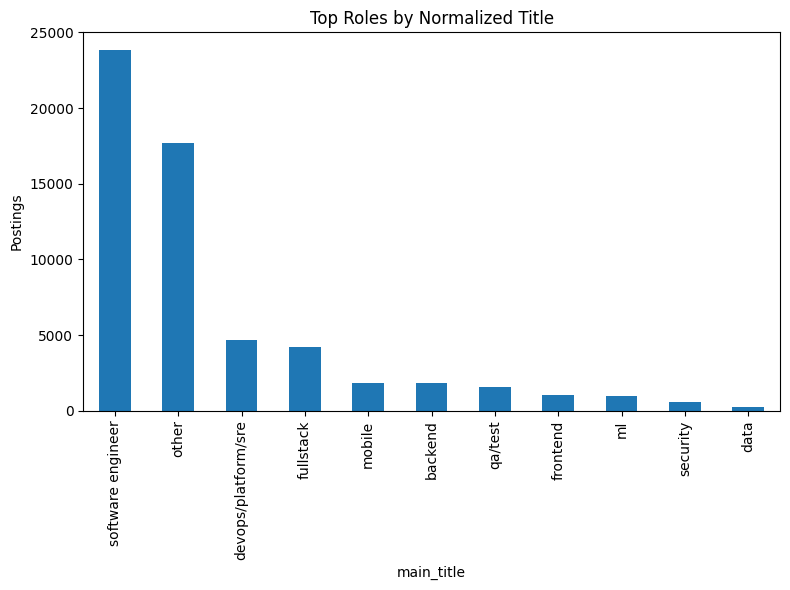

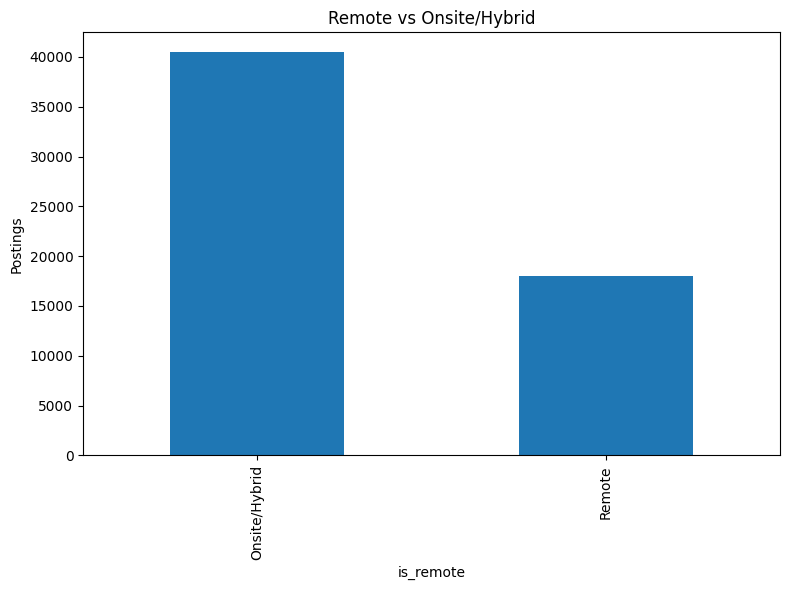

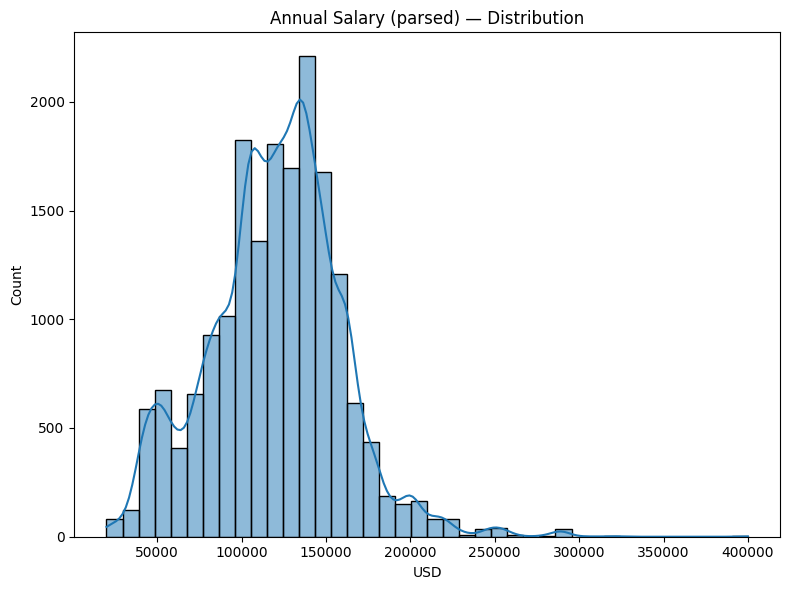

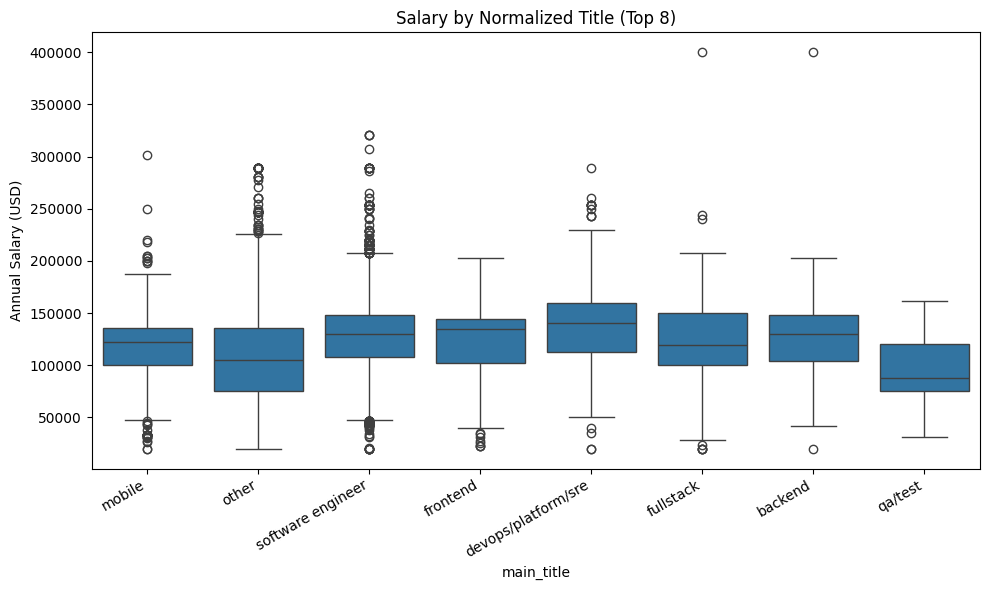

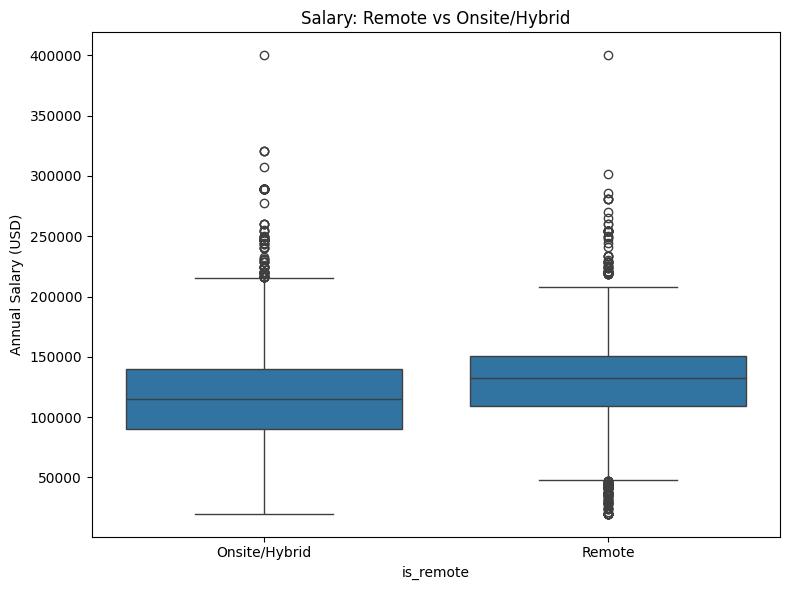

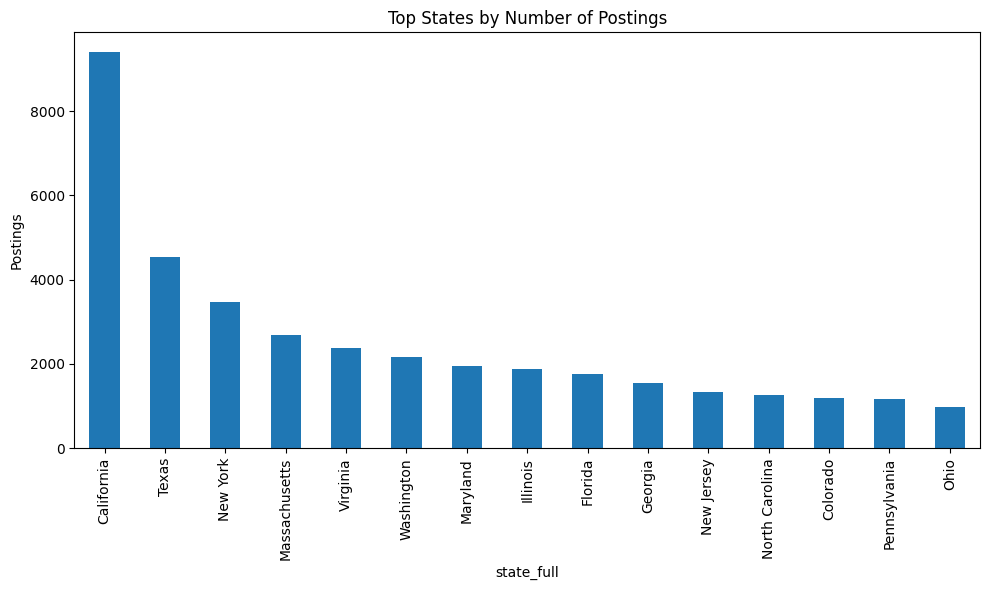

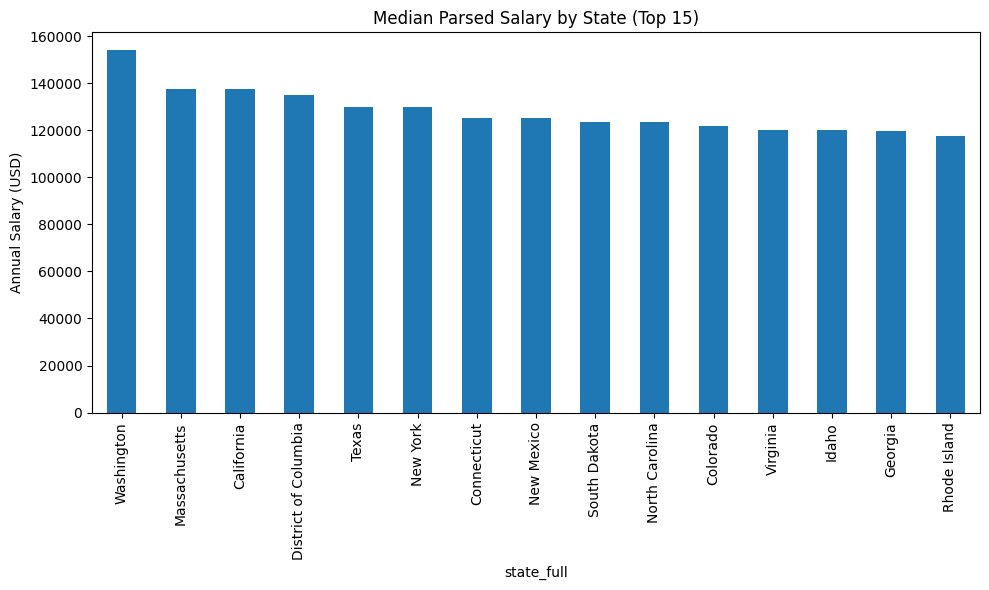

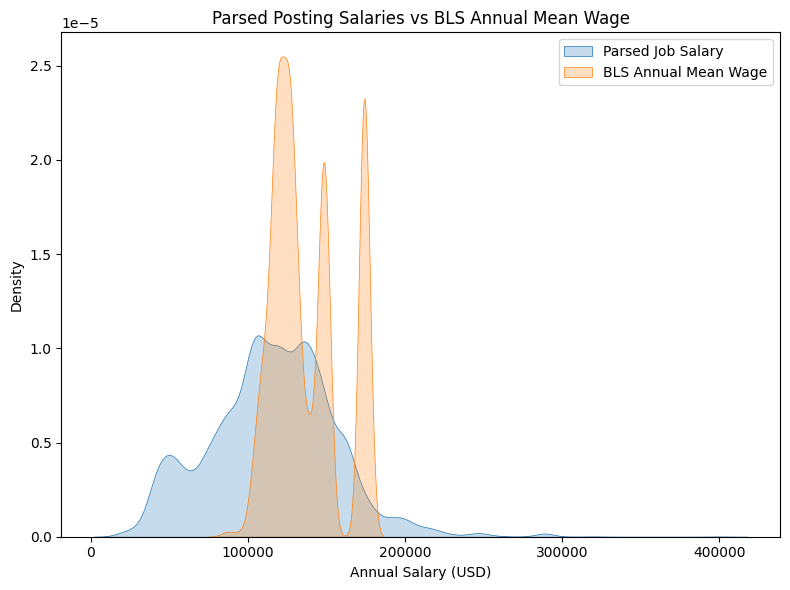

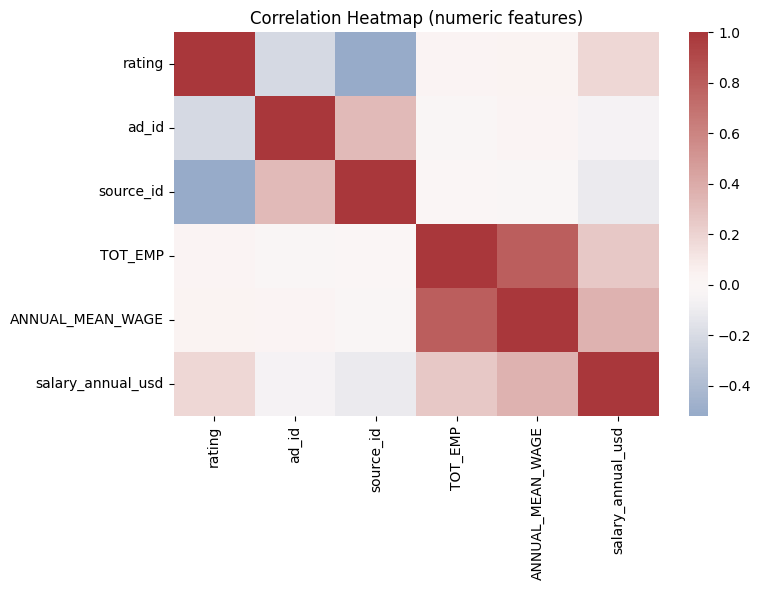

In [2]:
# =========================
# 0) Imports & display opts
# =========================

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)

# Create a working copy so we can experiment safely
df = merged_df.copy()

# =======================================================
# 1) Quick audit: shape, dtypes, missing, duplicates, etc.
# =======================================================
print("\n--- BASIC SHAPE & DTYPES ---")
print(df.shape)
print(df.dtypes)

print("\n--- MISSING VALUES (top 25) ---")
print(df.isna().sum().sort_values(ascending=False).head(25))

# Duplicates by (title, company, location) if those exist
dup_cols = [c for c in ["title","company","location"] if c in df.columns]
if dup_cols:
    num_dups = df.duplicated(subset=dup_cols).sum()
    print(f"\nPotential duplicate postings by {dup_cols}: {num_dups}")

# Peek
print("\n--- SAMPLE ROWS ---")
display_cols = [c for c in ["title","company","salary","location","is_remote","city","state","state_full","AREA_TITLE","TOT_EMP","ANNUAL_MEAN_WAGE"] if c in df.columns]
print(df[display_cols].head(10))

# ======================================
# 2) Feature cleanup / light engineering
# ======================================

# 2a) Salary parsing (robust but conservative):
# Handles cases like:
# "$120,000 - $160,000 a year", "$60 - $80 an hour", "From $140,000 a year", etc.
# Assumes full-time = 2080 hours/year for hourly → annual conversion.

def _to_number(x):
    # strip commas and $; keep digits and periods
    try:
        return float(re.sub(r"[^\d.]", "", x))
    except Exception:
        return np.nan

def parse_salary_to_annual(s):
    if not isinstance(s, str) or not s.strip():
        return np.nan

    text = s.lower()
    # Grab numbers
    nums = re.findall(r"\$?\s?[\d,]+(?:\.\d+)?", text)
    vals = [_to_number(n) for n in nums if _to_number(n) is not None]
    if not vals:
        return np.nan

    # Take the mid if it's a range, else the single value
    base = np.median(vals) if len(vals) >= 2 else vals[0]

    # Determine time basis
    is_hour = any(k in text for k in ["hour", "/hr", "per hour", "hr"])
    is_day  = "day" in text
    is_month= "month" in text
    is_year = any(k in text for k in ["year", "yr", "annum", "/yr"])

    # Heuristics: if nothing specified, assume annual if value is large, else hourly
    if not any([is_hour, is_day, is_month, is_year]):
        if base >= 1000:  # likely annual
            is_year = True
        else:
            is_hour = True

    annual = np.nan
    if is_year:
        annual = base
    elif is_hour:
        annual = base * 2080
    elif is_day:
        annual = base * 5 * 52  # 5 days/week * 52 weeks
    elif is_month:
        annual = base * 12

    # Handle suspicious extremes (clip to reasonable range)
    return np.clip(annual, 20000, 1_000_000) if pd.notna(annual) else np.nan

if "salary" in df.columns:
    df["salary_annual_usd"] = df["salary"].apply(parse_salary_to_annual)
else:
    df["salary_annual_usd"] = np.nan

# 2b) Seniority extraction from title
def infer_seniority(title):
    if not isinstance(title, str):
        return "unspecified"
    t = title.lower()
    if any(k in t for k in ["intern", "junior", "jr", "entry"]):
        return "junior"
    if any(k in t for k in ["senior", "sr", "staff", "lead", "principal", "architect", "manager","director"]):
        return "senior"
    return "mid"

df["seniority"] = df.get("title", pd.Series(dtype=str)).apply(infer_seniority)

# 2c) Normalize a "main_title" for grouping
def normalize_title(title):
    if not isinstance(title, str):
        return "other"
    t = title.lower()
    # very simple buckets—customize as needed
    if "data" in t and ("engineer" in t or "scientist" in t):
        return "data"
    if "backend" in t:
        return "backend"
    if "frontend" in t or "front-end" in t:
        return "frontend"
    if "full stack" in t or "full-stack" in t or "fullstack" in t:
        return "fullstack"
    if "ml" in t or "machine learning" in t:
        return "ml"
    if "devops" in t or "platform" in t or "site reliability" in t or "sre" in t:
        return "devops/platform/sre"
    if "mobile" in t or "ios" in t or "android" in t:
        return "mobile"
    if "qa" in t or "quality" in t or "test" in t:
        return "qa/test"
    if "security" in t:
        return "security"
    if "software" in t and "engineer" in t:
        return "software engineer"
    return "other"

df["main_title"] = df.get("title", pd.Series(dtype=str)).apply(normalize_title)

# 2d) Boolean/clean fields
if "is_remote" in df.columns:
    df["is_remote"] = df["is_remote"].fillna(False).astype(bool)
else:
    df["is_remote"] = df.get("remote_work_model", "").astype(str).str.contains("remote", case=False, na=False)

# Ensure a clean state label for groupbys
if "state_full" not in df.columns and "AREA_TITLE" in df.columns:
    df["state_full"] = df["AREA_TITLE"]

# ===================================
# 3) Univariate distributions/overview
# ===================================
plt.figure()
df["main_title"].value_counts().head(15).plot(kind="bar")
plt.title("Top Roles by Normalized Title")
plt.ylabel("Postings")
plt.tight_layout()

plt.figure()
remote_counts = df["is_remote"].value_counts(dropna=False)
remote_counts.index = remote_counts.index.map({True:"Remote", False:"Onsite/Hybrid", np.nan:"Unknown"})
remote_counts.plot(kind="bar")
plt.title("Remote vs Onsite/Hybrid")
plt.ylabel("Postings")
plt.tight_layout()

if df["salary_annual_usd"].notna().sum() > 0:
    plt.figure()
    sns.histplot(df["salary_annual_usd"].dropna(), bins=40, kde=True)
    plt.title("Annual Salary (parsed) — Distribution")
    plt.xlabel("USD")
    plt.tight_layout()

# ==========================================
# 4) Bivariate: salary vs role, remote, state
# ==========================================
if df["salary_annual_usd"].notna().sum() > 0:
    # Salary by main title (top 8)
    top_titles = df["main_title"].value_counts().head(8).index
    plt.figure(figsize=(10,6))
    sns.boxplot(
        data=df[df["main_title"].isin(top_titles)],
        x="main_title", y="salary_annual_usd"
    )
    plt.xticks(rotation=30, ha="right")
    plt.title("Salary by Normalized Title (Top 8)")
    plt.ylabel("Annual Salary (USD)")
    plt.tight_layout()

    # Salary by remote vs onsite
    plt.figure()
    sns.boxplot(
        data=df[df["salary_annual_usd"].notna()],
        x="is_remote", y="salary_annual_usd"
    )
    plt.xticks([0,1], ["Onsite/Hybrid","Remote"])
    plt.title("Salary: Remote vs Onsite/Hybrid")
    plt.ylabel("Annual Salary (USD)")
    plt.tight_layout()

# ===========================================
# 5) State-level view with BLS enrichment (if available)
# ===========================================
has_state = "state_full" in df.columns
if has_state:
    # Postings by state (top 15)
    plt.figure(figsize=(10,6))
    df["state_full"].value_counts().head(15).plot(kind="bar")
    plt.title("Top States by Number of Postings")
    plt.ylabel("Postings")
    plt.tight_layout()

    # Mean salary by state (only where we have parsed salaries)
    state_salary = (df.loc[df["salary_annual_usd"].notna()]
                      .groupby("state_full")["salary_annual_usd"]
                      .median()
                      .sort_values(ascending=False)
                      .head(15))
    if not state_salary.empty:
        plt.figure(figsize=(10,6))
        state_salary.plot(kind="bar")
        plt.title("Median Parsed Salary by State (Top 15)")
        plt.ylabel("Annual Salary (USD)")
        plt.tight_layout()

# Compare parsed salaries to BLS wage if both present
if "ANNUAL_MEAN_WAGE" in df.columns:
    comp = df[["salary_annual_usd","ANNUAL_MEAN_WAGE"]].dropna()
    if not comp.empty:
        plt.figure()
        sns.kdeplot(comp["salary_annual_usd"], label="Parsed Job Salary", fill=True, linewidth=0.5)
        sns.kdeplot(comp["ANNUAL_MEAN_WAGE"], label="BLS Annual Mean Wage", fill=True, linewidth=0.5)
        plt.legend()
        plt.title("Parsed Posting Salaries vs BLS Annual Mean Wage")
        plt.xlabel("Annual Salary (USD)")
        plt.tight_layout()

# ==================================
# 6) Correlation heatmap (numericals)
# ==================================
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    plt.figure(figsize=(8,6))
    corr = df[num_cols].corr(numeric_only=True)
    sns.heatmap(corr, cmap="vlag", center=0, annot=False)
    plt.title("Correlation Heatmap (numeric features)")
    plt.tight_layout()

# ===================================================
# 7) Quick tables you can export or review in console
# ===================================================
# Top companies and titles
if "company" in df.columns:
    print("\nTop companies by postings:")
    print(df["company"].value_counts().head(20))

print("\nTop normalized titles:")
print(df["main_title"].value_counts().head(20))

# Remote share by title
remote_by_title = (df.groupby("main_title")["is_remote"]
                     .mean()
                     .sort_values(ascending=False))  # fraction remote
print("\nRemote share by normalized title (fraction of postings labeled remote):")
print(remote_by_title.head(20))

# State-level summary merging postings + BLS
to_group = ["state_full"] if "state_full" in df.columns else ["AREA_TITLE"]
state_summary = (df.groupby(to_group)
                   .agg(
                       postings=("title","count"),
                       med_salary=("salary_annual_usd", "median"),
                       bls_tot_emp=("TOT_EMP","first"),
                       bls_mean_wage=("ANNUAL_MEAN_WAGE","first"),
                       remote_share=("is_remote","mean"),
                   )
                   .sort_values("postings", ascending=False))
print("\nState summary (postings, salary, BLS employment/wage, remote share):")
print(state_summary.head(15))


for i, fignum in enumerate(plt.get_fignums(), start=1):
     plt.figure(fignum)
     plt.savefig(f"eda_plot_{i:02d}.png", dpi=150, bbox_inches="tight")

plt.show()

# Model 1: Linear Regression
---
The goal of this model was to predict the number of software engineer job openings in the United States using state-level employment and salary data.

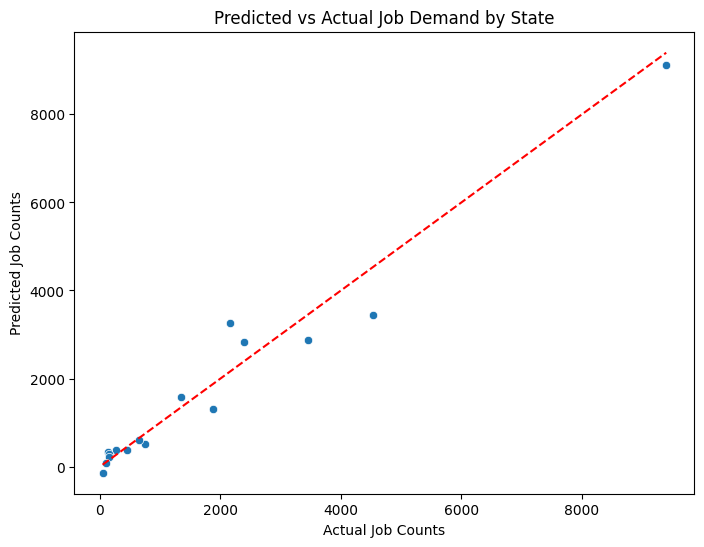

RMSE: 469.33312631447814


In [25]:
X = demand_df[['TOT_EMP', 'ANNUAL_MEAN_WAGE']]
y = demand_df['job_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model1 = LinearRegression()
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)

sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Job Counts")
plt.ylabel("Predicted Job Counts")
plt.title("Predicted vs Actual Job Demand by State")
plt.show()

print("RMSE:", RMSE)

Predicted vs Actual Software Engineer Salaries

# Model 2: KNN Regressor

---

The goal of this model is to predict software engineering salaries per state.

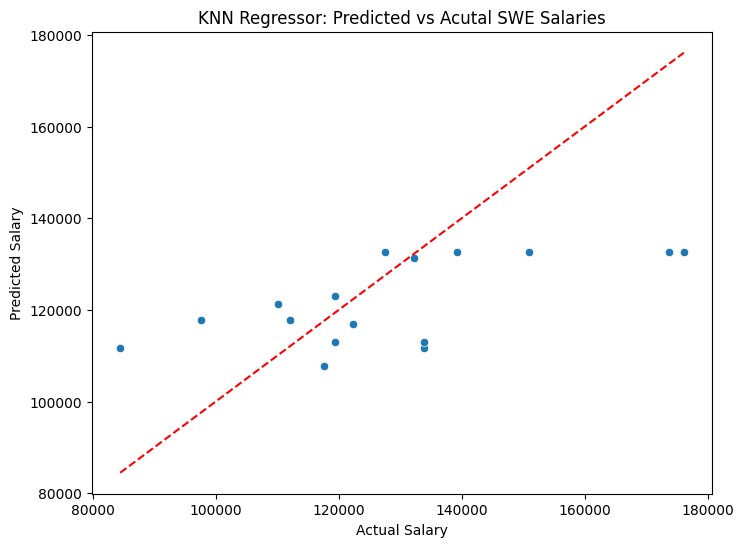

RMSE: 20019.835632853967


In [30]:
X = demand_df[['TOT_EMP', 'job_count']]
y = demand_df['ANNUAL_MEAN_WAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

MSE = mean_squared_error(y_test, y_pred_knn)
RMSE = np.sqrt(MSE)

sns.scatterplot(x=y_test, y=y_pred_knn)
plt.plot([y_test.min(), y_test.max()] , [y_test.min(), y_test.max()],  'r--')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("KNN Regressor: Predicted vs Acutal SWE Salaries")
plt.show()

print("RMSE:", RMSE)


# Model 3: Decision Tree Regressor
The goal of this model is to predict software engineering salaries per state.

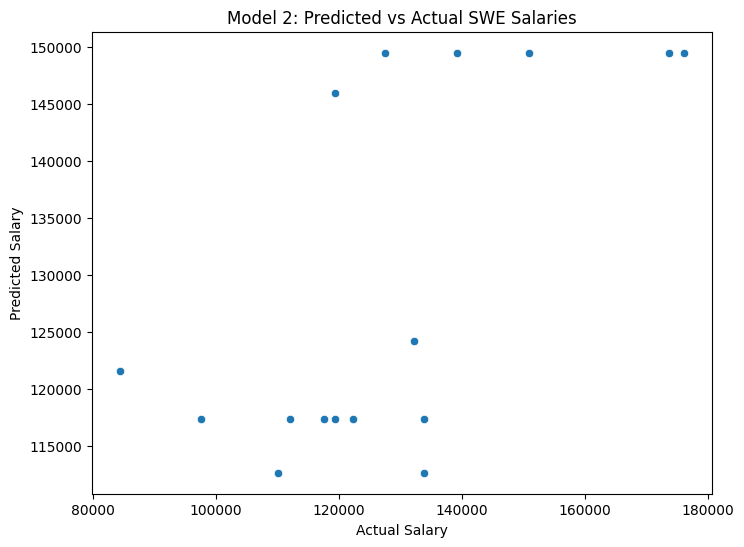

RMSE: 18030.404910997244


In [26]:
X = demand_df[['TOT_EMP', 'job_count']]
y = demand_df['ANNUAL_MEAN_WAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

tree_model = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)

sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Model 3: Predicted vs Actual SWE Salaries")
plt.show()

print("RMSE:", RMSE)

# Model 4: Random Forest Regressor
The goal of this model is to predict software engineering salaries per state.


RMSE: 18057.79884534969


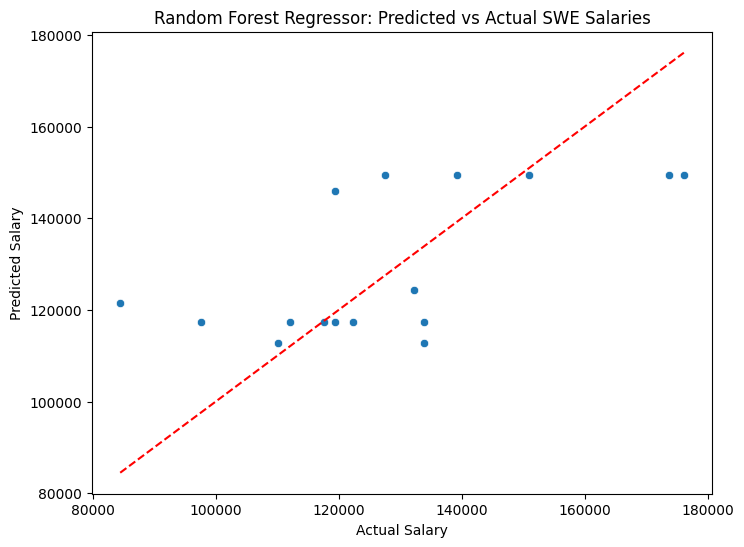

In [33]:
X = demand_df[['TOT_EMP', 'job_count']]
y = demand_df['ANNUAL_MEAN_WAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

MSE = mean_squared_error(y_test, y_pred_rf)
RMSE = np.sqrt(MSE)

print("RMSE:", RMSE)

sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()] , [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Random Forest Regressor: Predicted vs Actual SWE Salaries")
plt.show()